In [1]:
%load_ext autoreload
%autoreload 2

In [235]:
# --------------------
# Import general stuff
# --------------------
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator
from sklearn.manifold import MDS, Isomap
from sklearn.decomposition import PCA

# ----------------------------------
# Import Retention Order SVM classes
# ----------------------------------
from rosvm.ranksvm.rank_svm_cls import KernelRankSVC
from rosvm.ranksvm.analysis_utils import RankSVMAnalyzer
from rosvm.ranksvm.tutorial.utils import read_dataset
from rosvm.feature_extraction.featurizer_cls import CircularFPFeaturizer
from rosvm.ranksvm.kernel_utils import generalized_tanimoto_kernel, minmax_kernel

## Load Example Data

We work with the seven publicly available datasets. Those include retention times measured on different chromatographic systems.

In [189]:
X, y, mol = read_dataset("./example_data_2_mol_desc.csv")  
print("Number of Measurements:", len(y))

# Number of examples per dataset
print("Datasets:")
datasets, y_cts = y.get_unique_dss(return_counts=True)
for d, c in zip(datasets, y_cts):
    print("\t%s - #samples=%d" % (d, c))
    
for _ds in y.get_unique_dss():
    assert(np.all(np.diff(y.get_idc_for_ds(_ds)) == 1))

Number of Measurements: 1461
Datasets:
	Boudah_et_al_2014_C18 - #samples=169
	Eawag_XBridgeC18 - #samples=320
	Eugster_et_al_2015 - #samples=221
	FEM_long - #samples=299
	LIFE_new - #samples=100
	LIFE_old - #samples=96
	RIKEN - #samples=158
	UniToyama_Atlantis - #samples=98


### Inspect the Chemical Space

We first compute the ECFP representation for all molecules and subsequently the MinMax kernel matrix. This similarity matrix is used as input for example for the Multidimensional Scaling (MDS).

In [226]:
# ECFP
X_ecfp_count = CircularFPFeaturizer(only_freq_subs=True, min_subs_freq=0.05, output_dense_matrix=True) \
    .fit_transform(mol)
print("ECFP feature matrix:", X_ecfp_count.shape)

K_ecfp = minmax_kernel(X_ecfp_count)

# Substructure
K_ss = minmax_kernel(X)

ECFP feature matrix: (1461, 112)


#### Multi-dimensional Scaling (MDS)

Get a two-dimensional embedding of the data.

In [227]:
X_ecfp_mds = MDS(dissimilarity="precomputed", n_jobs=4).fit_transform(1 - K_ecfp)
X_ss_mds = MDS(dissimilarity="precomputed", n_jobs=4).fit_transform(1 - K_ss)

For comparison, we also use the substructure fingerprint vectors for the MDS. Again through a MinMax kernel matrix.

Text(0.5, 1.0, 'Substructure')

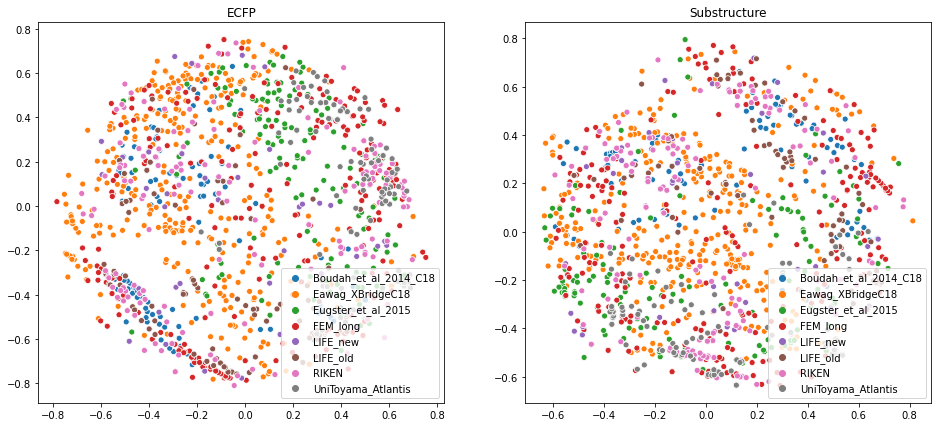

In [228]:
fig, axrr = plt.subplots(1, 2, figsize=(16, 7))
sns.scatterplot(X_ecfp_mds[:, 0], X_ecfp_mds[:, 1], hue=y.get_dss(), ax=axrr[0])
axrr[0].set_title("ECFP")
sns.scatterplot(X_ss_mds[:, 0], X_ss_mds[:, 1], hue=y.get_dss(), ax=axrr[1])
axrr[1].set_title("Substructure")

Use both fingerprint representations show, that the chemical spaces of the different datasets overlap quite much.

#### Isomap

In [233]:
X_ecfp_iso = Isomap(metric="precomputed", n_jobs=4).fit_transform(1 - K_ecfp)
X_ss_iso = Isomap(metric="precomputed", n_jobs=4).fit_transform(1 - K_ss)

Text(0.5, 1.0, 'Substructure')

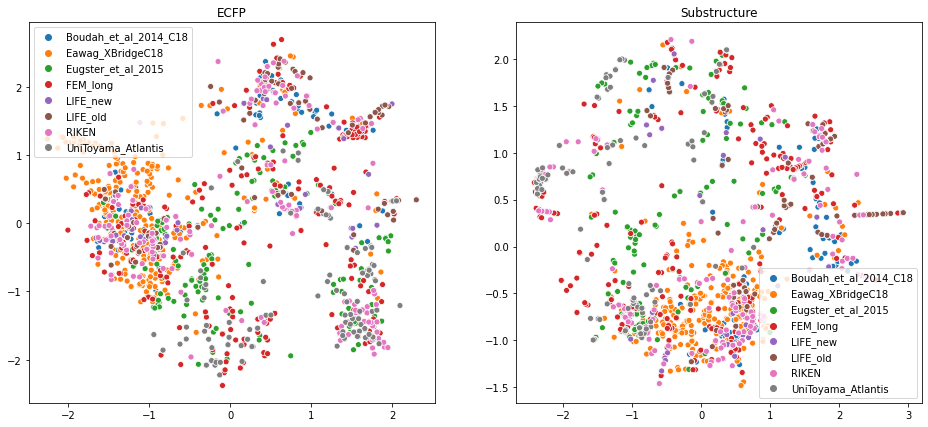

In [234]:
fig, axrr = plt.subplots(1, 2, figsize=(16, 7))
sns.scatterplot(X_ecfp_iso[:, 0], X_ecfp_iso[:, 1], hue=y.get_dss(), ax=axrr[0])
axrr[0].set_title("ECFP")
sns.scatterplot(X_ss_iso[:, 0], X_ss_iso[:, 1], hue=y.get_dss(), ax=axrr[1])
axrr[1].set_title("Substructure")

#### PCA

Text(0.5, 1.0, 'Substructure')

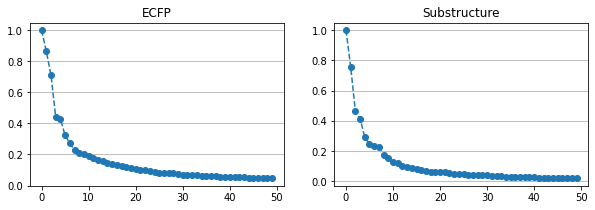

In [250]:
ecfp_pca = PCA(n_components=50).fit(X_ecfp_count)
ss_pca = PCA(n_components=50).fit(X)

fig, axrr = plt.subplots(1, 2, figsize=(10, 3))
axrr[0].plot(ecfp_pca.singular_values_ / np.max(ecfp_pca.singular_values_), 'o--')
axrr[0].grid(axis="y")
axrr[0].set_title("ECFP")
axrr[1].plot(ss_pca.singular_values_ / np.max(ss_pca.singular_values_), 'o--')
axrr[1].grid(axis="y")
axrr[1].set_title("Substructure")

Text(0.5, 1.0, 'Substructure')

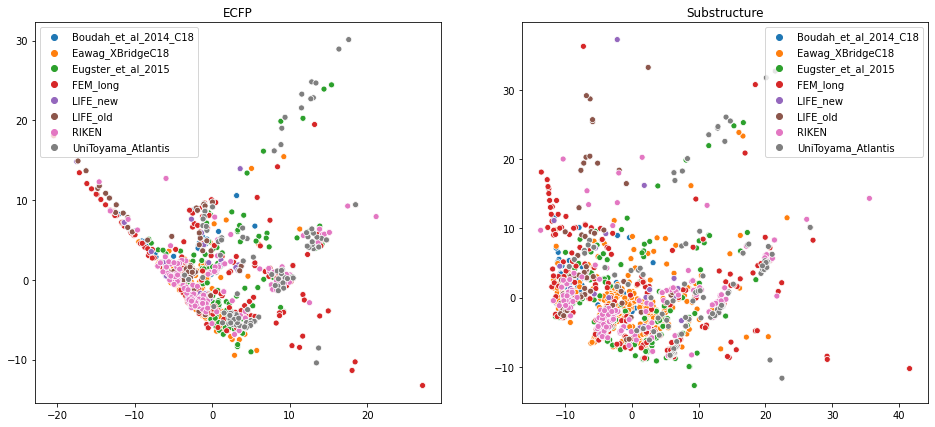

In [238]:
fig, axrr = plt.subplots(1, 2, figsize=(16, 7))
sns.scatterplot(X_ecfp_pca[:, 0], X_ecfp_pca[:, 1], hue=y.get_dss(), ax=axrr[0])
axrr[0].set_title("ECFP")
sns.scatterplot(X_ss_pca[:, 0], X_ss_pca[:, 1], hue=y.get_dss(), ax=axrr[1])
axrr[1].set_title("Substructure")

**Mobile Phase Gradients** are extracted from the publications

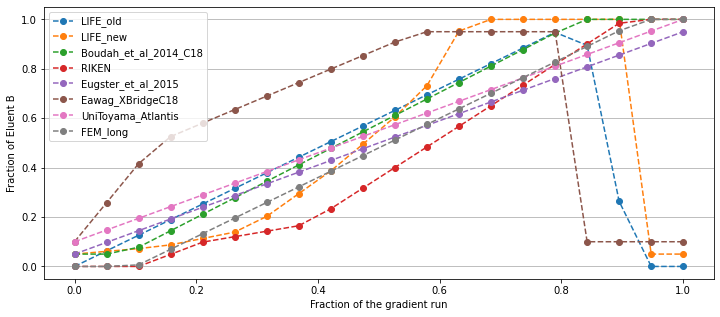

In [117]:
# Gradients: time t and corresponding percentage of eluent B
grads = {
    "LIFE_old": np.array([[0.0, 5.0, 5.5, 6.0], [0.0, 100.0, 0.0, 0.0]]),
    "LIFE_new": np.array([[0.0, 1.0, 2.0, 3.0, 4.0, 4.5, 5.0, 6.4, 6.6, 6.8, 7.0],
                          [5, 8, 15, 40, 70, 100, 100, 100, 5.0, 5.0, 5.0]]),
    "Boudah_et_al_2014_C18": np.array([[0.0, 2.0, 20, 24], [5, 5, 100, 100]]),
    "RIKEN": np.array([[0.0, 0.25, 0.4, 0.8, 1.9, 2.1],
                       [0.0, 0.0, 9.0, 17.0, 100.0, 100.0]]),
    "Eugster_et_al_2015": np.array([[0.0, 30.0], [5, 95]]),
    "Eawag_XBridgeC18": np.array([[0.0, 4.0, 17.0, 25.0, 25.1, 30.0],
                                  [10.0, 50.0, 95.0, 95.0, 10.0, 10.0]]),
    "UniToyama_Atlantis": np.array([[0.0, 40.0], [10.0, 100.0]]),
    "FEM_long": np.array([[0.0, 6.0, 56.0, 60.0], [0.0, 0.0, 100.0, 100.0]])
}

n_samples_points = 20
grads_as_funcs = {
    k: np.interp(np.linspace(0, 1, n_samples_points), v[0] / np.max(v[0]), v[1] / 100)
    for k, v in grads.items()
}

plt.figure(figsize=(12, 5))

for k, fx in grads_as_funcs.items():
    plt.plot(np.linspace(0, 1, n_samples_points), fx, 'o--', label=k)
    
plt.legend()
plt.xlabel("Fraction of the gradient run")
plt.ylabel("Fraction of Eluent B")
plt.grid(axis="y")
plt.show()

Load the descriptors of the different systems

In [83]:
def read_system_descriptors(fn, grads_as_funcs):
    # LogP values are taken from PubChem
    logP = {"H2O": -1.38, "CH4O": -0.77, "C3H6O": -0.24, "C2H3N": -0.34}
    
    # Read and parse the information for the column (stationary phase) used in the chromatographic system
    df_col = pd.read_csv(fn, sep="\t")[["name", "temperature", "flowrate", "desc_hsm"]]
    df_col[["hsm_1", "hsm_2", "hsm_3", "hsm_4", "hsm_5", "hsm_6", "hsm_7"]] = df_col.desc_hsm.str.split(",", expand=True)
    df_col = df_col.drop("desc_hsm", axis=1)
    df_col = df_col.rename(columns={"name": "dataset"})
    df_col = df_col.sort_values(by="dataset")

    # Read the information related to the mobile phase
    df_elu = pd.read_csv(fn, sep="\t", usecols=["name", "eluent_A_mol", "eluent_A_con", "eluent_B_mol", "eluent_B_con"], 
                         dtype={"name": str, "eluent_A_mol": str, "eluent_A_con": str, 
                                "eluent_B_mol": str, "eluent_B_con": str})
    df_elu = df_elu.rename(columns={"name": "dataset"})
    df_elu = df_elu.set_index("dataset")
    
    # Replace the mobile phase molecules with their logp values
    df_elu = df_elu.apply(lambda row: [np.average([logP[v] for v in row[0].split(",")], 
                                     weights=np.array([v for v in row[1].split(",")], dtype="float") / 100.),
                          np.average([logP[v] for v in row[2].split(",")], 
                                     weights=np.array([v for v in row[3].split(",")], dtype="float") / 100.)],
                          axis=1, result_type="expand") \
        .reset_index() \
        .rename(columns={0: "eluent_A_logp", 1: "eluent_B_logp"}) \
        .sort_values(by="dataset")
    
    df_elu_grad = df_elu.apply(lambda row: [row[0]] + 
                               ((1 - grads_as_funcs[row[0]]) * row[1] + grads_as_funcs[row[0]] * row[2]).tolist(),
             axis=1, result_type="expand") \
        .rename(columns={0: "dataset"}) \
        .sort_values(by="dataset")
    
    return df_col, df_elu, df_elu_grad

df_col, df_elu, df_elu_grad = read_system_descriptors("./example_data_2_cs_desc.csv", grads_as_funcs)

<AxesSubplot:>

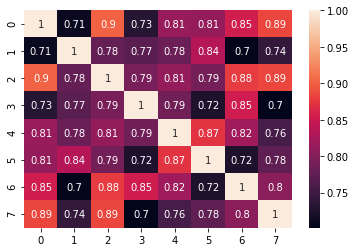

In [84]:
sns.heatmap(generalized_tanimoto_kernel(df_elu_grad.iloc[:, 1:].values), annot=True)

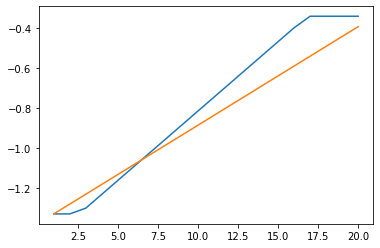

In [164]:
plt.plot(df_elu_grad.iloc[0,1:])
plt.plot(df_elu_grad.iloc[2,1:])

<AxesSubplot:>

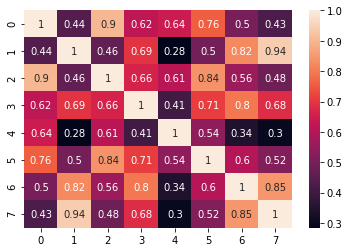

In [68]:
sns.heatmap(generalized_tanimoto_kernel(df_col.iloc[:, 1:].values.astype("float")), annot=True)

In [146]:
X_col = np.repeat(df_col.iloc[:, 1:4].values.astype("float"), y_cts, axis=0)
X_elu = np.repeat(df_elu.iloc[:, 1:].values.astype("float"), y_cts, axis=0)
X_elu_grad = np.repeat(df_elu_grad.iloc[:, 1:].values.astype("float"), y_cts, axis=0)

In [87]:
generalized_tanimoto_kernel(X_elu)

array([[1.        , 1.        , 1.        , ..., 0.88502448, 0.88502448,
        0.88502448],
       [1.        , 1.        , 1.        , ..., 0.88502448, 0.88502448,
        0.88502448],
       [1.        , 1.        , 1.        , ..., 0.88502448, 0.88502448,
        0.88502448],
       ...,
       [0.88502448, 0.88502448, 0.88502448, ..., 1.        , 1.        ,
        1.        ],
       [0.88502448, 0.88502448, 0.88502448, ..., 1.        , 1.        ,
        1.        ],
       [0.88502448, 0.88502448, 0.88502448, ..., 1.        , 1.        ,
        1.        ]])

## Evaluate different Models

Here, we are evaluating different RankSVM models with and without additional features of the chromatographic system. Thereby we run a Leave-Dataset-Out evaluation. 

```Python
C_grid = [2**-4, ..., 2**4]
sim_threshold = quantile(pairwise_similarities(X, X), 0.9)

for dataset in DATASETS:
    # TEST-SET: Get molecule, features and labels for the current dataset
    X_test, y_test, mols_test = X[dataset], y[dataset], mols[dataset]
    
    # TRAIN-SET: 
    X_train, y_train, mols_train = X[~dataset], y[~dataset], mols[~dataset]
    
    # Remove very molecules from the training set, that are too similar to the test set
    sim_train_to_test = pairwise_similarities(X_train, X_test)
    X_train = X_train[sim_train_to_test >= sim_treshold]
    y_train = y_train[sim_train_to_test >= sim_treshold]
    mols_train = mols_train[sim_train_to_test < sim_treshold]
    
    # Train the RankSVM model 
    model = gridsearchcv(X_train, y_train, mols_train, C_grid)
    
    # Calcualte the test set performance 
    perf_test[dataset] = model.score(X_test, y_test)
```

### Without System Descriptors

In [139]:
gridsearchcv = GridSearchCV(estimator=KernelRankSVC(kernel="minmax", random_state=102), 
                            param_grid={"C": [2]},
                            cv=GroupKFold(n_splits=3),
                            n_jobs=4)

test_score = []
for idx, (train, test) in enumerate(GroupKFold(n_splits=8).split(y, groups=y.get_dss())):
    ranksvm = gridsearchcv.fit(X[train], y[train], groups=mol[train])
    print("Split %d/%d: cindex=%.3f" % (idx + 1, 5, ranksvm.score(X[test], y[test])))

Split 1/5: cindex=0.704
Split 2/5: cindex=0.893
Split 3/5: cindex=0.869
Split 4/5: cindex=0.838
Split 5/5: cindex=0.867
Split 6/5: cindex=0.864
Split 7/5: cindex=0.761
Split 8/5: cindex=0.862


### With System Descriptors

In [166]:
gridsearchcv = GridSearchCV(estimator=KernelRankSVC(kernel="minmax", random_state=102), 
                            param_grid={"C": [0.5, 1, 2, 4, 8]},
                            cv=GroupKFold(n_splits=3),
                            n_jobs=4)

KX = generalized_tanimoto_kernel(X)
KX_elu = generalized_tanimoto_kernel(X_elu)
KX_elu_grad = generalized_tanimoto_kernel(X_elu_grad)
KX_col = generalized_tanimoto_kernel(X_col)

for idx, (train, test) in enumerate(GroupKFold(n_splits=8).split(y, groups=y.get_dss())):
    KX_train = KX[np.ix_(train, train)]
    KX_elu_train = KX_elu[np.ix_(train, train)]
    KX_elu_grad_train = KX_elu_grad[np.ix_(train, train)]
    KX_col_train = KX_col[np.ix_(train, train)]
    
    KX_test = KX[np.ix_(test, train)]
    KX_elu_test = KX_elu[np.ix_(test, train)]
    KX_elu_grad_test = KX_elu_grad[np.ix_(test, train)]
    KX_col_test = KX_col[np.ix_(test, train)]
    
    ranksvm = KernelRankSVC(kernel="precomputed", random_state=102, C=1, pair_generation="eccb") \
        .fit(KX_train, y[train])
    
    print("Split %d/%d: cindex=%.3f" % (
        idx + 1, 5, ranksvm.score(KX_test, y[test])))

Split 1/5: cindex=0.725
Split 2/5: cindex=0.904
Split 3/5: cindex=0.888
Split 4/5: cindex=0.861
Split 5/5: cindex=0.869
Split 6/5: cindex=0.872
Split 7/5: cindex=0.806
Split 8/5: cindex=0.906


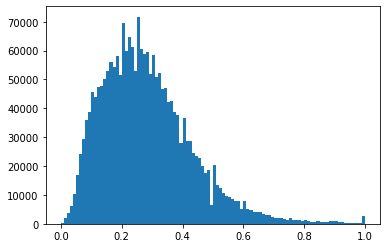

In [151]:
_ = plt.hist(KX.flatten(), 100)

In [165]:
gridsearchcv = GridSearchCV(estimator=KernelRankSVC(kernel="minmax", random_state=102), 
                            param_grid={"C": [0.5, 1, 2, 4, 8]},
                            cv=GroupKFold(n_splits=3),
                            n_jobs=4)

KX = generalized_tanimoto_kernel(X)
KX_elu = generalized_tanimoto_kernel(X_elu)
KX_elu_grad = generalized_tanimoto_kernel(X_elu_grad)
KX_col = generalized_tanimoto_kernel(X_col)

for idx, (train, test) in enumerate(GroupKFold(n_splits=8).split(y, groups=y.get_dss())):
    KX_train = KX[np.ix_(train, train)]
    KX_elu_train = KX_elu[np.ix_(train, train)]
    KX_elu_grad_train = KX_elu_grad[np.ix_(train, train)]
    KX_col_train = KX_col[np.ix_(train, train)]
    
    KX_test = KX[np.ix_(test, train)]
    KX_elu_test = KX_elu[np.ix_(test, train)]
    KX_elu_grad_test = KX_elu_grad[np.ix_(test, train)]
    KX_col_test = KX_col[np.ix_(test, train)]
    
    ranksvm = KernelRankSVC(kernel="precomputed", random_state=102, C=1, pair_generation="eccb") \
        .fit(KX_train * KX_elu_grad_train, y[train])
    
    print("Split %d/%d: cindex=%.3f" % (
        idx + 1, 5, ranksvm.score(KX_test * KX_elu_grad_test, y[test])))

Split 1/5: cindex=0.730
Split 2/5: cindex=0.879
Split 3/5: cindex=0.891
Split 4/5: cindex=0.836
Split 5/5: cindex=0.885
Split 6/5: cindex=0.931
Split 7/5: cindex=0.835
Split 8/5: cindex=0.910


### Without System Descriptors

In [93]:
gridsearchcv = GridSearchCV(estimator=KernelRankSVC(kernel="minmax", random_state=102, pairwise_features="exterior_product"), 
                            param_grid={"C": [0.5, 1, 2, 4, 8]},
                            cv=GroupKFold(n_splits=3),
                            n_jobs=4)

test_score = []
for idx, (train, test) in enumerate(GroupKFold(n_splits=5).split(y, groups=mol)):
    ranksvm = gridsearchcv.fit(X[train], y[train], groups=mol[train])
    print("Split %d/%d: cindex=%.3f" % (idx + 1, 5, ranksvm.score(X[test], y[test])))
    # for d, s in ranksvm.best_estimator_.score(X[test], y[test], return_score_per_dataset=True).items():
    #    print("\t'%s': cindex=%.3f" % (d, s[0]))

Split 1/5: cindex=0.878
Split 2/5: cindex=0.888
Split 3/5: cindex=0.866
Split 4/5: cindex=0.863
Split 5/5: cindex=0.853


### With System Descriptors

In [92]:
gridsearchcv = GridSearchCV(estimator=KernelRankSVC(kernel="minmax", random_state=102, pairwise_features="exterior_product"), 
                            param_grid={"C": [0.5, 1, 2, 4, 8]},
                            cv=GroupKFold(n_splits=3),
                            n_jobs=4)

test_score = []
for idx, (train, test) in enumerate(GroupKFold(n_splits=5).split(y, groups=mol)):
    ranksvm = gridsearchcv.fit(np.column_stack((X[train], X_elu[train])), y[train], groups=mol[train])
    print("Split %d/%d: cindex=%.3f" % (idx + 1, 5, ranksvm.score(np.column_stack((X[test], X_elu[test])), y[test])))
    #for d, s in ranksvm.best_estimator_.score(np.column_stack((X[test], X_elu[test])), y[test], return_score_per_dataset=True).items():
    #    print("\t'%s': cindex=%.3f" % (d, s[0]))

Split 1/5: cindex=0.879
Split 2/5: cindex=0.904
Split 3/5: cindex=0.877
Split 4/5: cindex=0.863
Split 5/5: cindex=0.861
